<a href="https://colab.research.google.com/github/HaikhalRirihW/Tugas-Installasi-Wordpress/blob/main/Haikhal_Ririh_Widyandaru_09011282025061_SK5A_UTS_Praktikum_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deteksi Masker Pada Muka Menggunakan Teknik Deep Learning

09011282025061_Haikhal Ririh Widyandaru

Project UTS Praktikum Kecerdasan Buatan Program Machine Learning untuk mendeteksi penggunaan masker. Program dibuat menggunakan metode CNN dengan arsitektur VGG16Net dan MTCNN untuk face detection.

In [1]:
!nvidia-smi

Tue Nov  1 20:28:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Memeriksa CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


## Tahap Awal

In [3]:
# Melakukan cloning data
!git clone https://github.com/Soedirman-Machine-Learning/face-mask-detection.git

Cloning into 'face-mask-detection'...
remote: Enumerating objects: 4737, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 4737 (delta 19), reused 35 (delta 19), pack-reused 4701
Receiving objects: 100% (4737/4737), 469.11 MiB | 31.36 MiB/s, done.
Resolving deltas: 100% (119/119), done.
Checking out files: 100% (4424/4424), done.


In [4]:
# Berpindah ke folder face-mask-detection
%cd face-mask-detection/

# Memeriksa isi folder face-mask-detection
!ls

/content/face-mask-detection
'aplikasi android'
 Aplikasi-Android.gif
'berkas tugas akhir'
 dataset
 face-detector.zip
 Face_Mask_Detection_MobileNetV2_with_MTCNN.ipynb
 Face_Mask_Detection_MobileNetV2_with_ResNet10.ipynb
 Face_Mask_Detection_VGG16Net_with_MTCNN.ipynb
 Face_Mask_Detection_VGG16Net_with_ResNet10.ipynb
 Full_Face_Mask_Detection_MobileNetV2.ipynb
 Full_Face_Mask_Detection_VGG16Net.ipynb
 logo-md1png.png
 mask_model.tflite
 pengujian
 README.md


**Face-detector.zip** merupakan file untuk melakukan pengujian model dengan menggunakan res10_300x300_ssd_iter_140000.caffemodel dan deploy.prototxt untuk mendeteksi bagian wajah

In [5]:
# Melakukan unzip pada folder face-detector.zip
!unzip face-detector.zip

Archive:  face-detector.zip
  inflating: deploy.prototxt         
  inflating: example_img/ex01.jpg    
  inflating: example_img/ex02.jpg    
  inflating: example_img/ex03.jpg    
  inflating: example_img/ex04.jpg    
  inflating: example_img/ex05.jpg    
  inflating: example_img/ex06.jpg    
  inflating: example_img/ex07.jpg    
  inflating: example_img/ex08.jpg    
  inflating: example_img/ex09.jpg    
  inflating: example_img/ex10.jpg    
  inflating: res10_300x300_ssd_iter_140000.caffemodel  


## Mengimpor Libraries yang dibutuhkan

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools
 
# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime
 
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 14.1 MB/s 
time: 423 µs (started: 2022-11-01 20:34:27 +00:00)


In [7]:
# Memeriksa Versi TensorFlow
print(tf.__version__)

2.9.2
time: 2.02 ms (started: 2022-11-01 20:35:10 +00:00)


## Preprocessing Datasets

In [8]:
# Inisialisasi nilai Initial Learning Rate, berapa banyak Epoch pelatihan, dan Batch Size
INIT_LR = 1e-4
EPOCHS = 30
BS = 32
 
# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Menginput gambar...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
 
# Melakukan perulangan pada image paths
for imagePath in imagePaths:
 
    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Memuat input gambar (224x224) dan melakukan proses
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
 
    # Mengupdate data dan labels lists, berurutan
    data.append(image)
    labels.append(label)
 
# Mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
 
# Melakukan one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("Input gambar berhasil")

Menginput gambar...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Input gambar berhasil
time: 14.1 s (started: 2022-11-01 20:35:16 +00:00)


### Membuat objek ImageDataGenerator dan Data Augmentation

In [9]:
# Mempartisi data ke dalam pelatihan dan pengujian ( 75% : 25% )
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
 
# Membentuk training image generator untuk data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

time: 909 ms (started: 2022-11-01 20:35:43 +00:00)


## Membuat Model Jaringan CNN yang sudah dipelajari sebelumnya (pre-trained convnets)

In [10]:
# Arsitektur jaringan VGG16Net
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 1s 0us/step
time: 4.41 s (started: 2022-11-01 20:35:49 +00:00)


### Feature Extraction

In [11]:
baseModel.trainable = False
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Tahap Pembuatan Model

In [12]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)
 
# Perulangan pada seluruh base model
for layer in baseModel.layers:
    layer.trainable = False
 
# Persiapan kompilasi model
print("Mengkompilasi model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

Mengkompilasi model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Melakukan Pelatihan Model

In [13]:
# Pelatihan model
print("Training head model...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training head model...
Epoch 1/30
95/95 [==============================] - 55s 479ms/step - loss: 0.6663 - accuracy: 0.6163 - val_loss: 0.5617 - val_accuracy: 0.9531
Epoch 2/30
95/95 [==============================] - 37s 391ms/step - loss: 0.5710 - accuracy: 0.7643 - val_loss: 0.4622 - val_accuracy: 0.9413
Epoch 3/30
95/95 [==============================] - 38s 405ms/step - loss: 0.4703 - accuracy: 0.8754 - val_loss: 0.3776 - val_accuracy: 0.9518
Epoch 4/30
95/95 [==============================] - 41s 430ms/step - loss: 0.4024 - accuracy: 0.9034 - val_loss: 0.3109 - val_accuracy: 0.9531
Epoch 5/30
95/95 [==============================] - 39s 406ms/step - loss: 0.3470 - accuracy: 0.9225 - val_loss: 0.2613 - val_accuracy: 0.9583
Epoch 6/30
95/95 [==============================] - 38s 401ms/step - loss: 0.3018 - accuracy: 0.9258 - val_loss: 0.2231 - val_accuracy: 0.9661
Epoch 7/30
95/95 [==============================] - 40s 415ms/step - loss: 0.2664 - accuracy: 0.9357 - val_loss: 0.1971

KeyboardInterrupt: ignored

time: 4min 58s (started: 2022-11-01 20:36:18 +00:00)


## Menampilkan Grafik Model Hasil Pelatihan

NameError: ignored

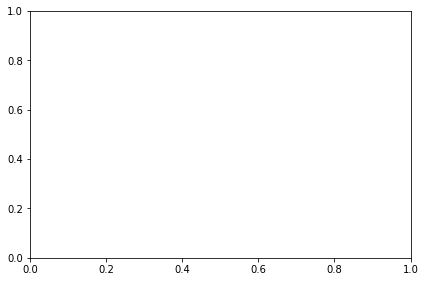

time: 174 ms (started: 2022-11-01 20:41:30 +00:00)


In [14]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Akurasi")
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

## Evaluasi Jaringan

In [15]:
# Memeriksa matriks model
print(model.metrics_names)
# Evaluasi data test
print(model.evaluate(x= testX, y = testY))

['loss', 'accuracy']
24/24 [==============================] - 6s 263ms/step - loss: 0.1963 - accuracy: 0.9648
[0.19630123674869537, 0.9647979140281677]
time: 6.76 s (started: 2022-11-01 20:41:42 +00:00)


In [16]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(testY, axis=1)

# Label prediksi
YPred = model.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

24/24 [==============================] - 4s 151ms/step
[0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1
 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0
 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1
 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1
 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1
 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1
 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 

## Confusion Matrix

In [17]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue)) 
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

time: 1.62 ms (started: 2022-11-01 20:42:04 +00:00)


In [18]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[375,   8],
       [ 19, 365]])

time: 4.18 ms (started: 2022-11-01 20:42:08 +00:00)


Text(0.5, 15.0, 'Label Prediksi')

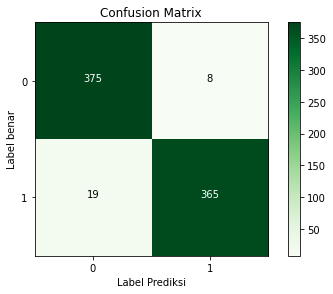

time: 464 ms (started: 2022-11-01 20:42:11 +00:00)


In [19]:
classes = [0, 1]
# Plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Label benar')
plt.xlabel('Label Prediksi')

Analisis mAP

In [20]:
# Berdasarkan confusion matrix
TP = true_pos = 376
TN = true_neg = 375
FP = false_pos = 8
FN = false_neg = 8

time: 1.19 ms (started: 2022-11-01 20:42:16 +00:00)


In [21]:
results = {}

# Akurasi
metric = "Akurasi"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Recall
metric = "Recall"
results[metric] = TP / (TP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Presisi
metric = "Presisi"
results[metric] = TP / (TP + FP)
print(f"{metric} = {results[metric]: .3f}")

# Nilai F1
metric = "F1"
results[metric] = 2 / (1 / results["Presisi"] + 1 / results["Recall"])
print(f"{metric} = {results[metric]: .3f}")

Akurasi =  0.979
Recall =  0.979
Presisi =  0.979
F1 =  0.979
time: 2.82 ms (started: 2022-11-01 20:42:19 +00:00)


In [22]:
# Membuat prediksi dari pengujian
predIdxs = model.predict(testX, batch_size=BS)
 
# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)
 
# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

24/24 [==============================] - 3s 150ms/step
              precision    recall  f1-score   support

   with_mask       0.95      0.98      0.97       383
without_mask       0.98      0.95      0.96       384

    accuracy                           0.96       767
   macro avg       0.97      0.96      0.96       767
weighted avg       0.97      0.96      0.96       767

time: 3.91 s (started: 2022-11-01 20:42:23 +00:00)


# Pengujian Model dengan MTCNN

Model diujikan pada gambar dan secara real-time dengan menggunakan MTCNN yang digunakan untuk mendeteksi wajah.

In [23]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 13.7 MB/s 
time: 3.83 s (started: 2022-11-01 20:44:34 +00:00)


## Penggunaan Model pada Gambar


In [24]:
from mtcnn import MTCNN
import cv2
from google.colab.patches import cv2_imshow

time: 20.6 ms (started: 2022-11-01 20:44:51 +00:00)


In [25]:
detector = MTCNN()
image = cv2.imread('/content/face-mask-detection/example_img/ex5.jpg', cv2.COLOR_BGR2RGB)
faces = detector.detect_faces(image)
for result in faces:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h
    
    # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
    # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
    face = image[y:y1, x:x1]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)    

    # Membaca wajah dengan model
    (mask, withoutMask) = model.predict(face)[0]

    # Menggunakan masker hijau, tidak bermasker merah
    label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
    color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

		# Probabilitas hasil deteksi
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

    # Menampilkan hasil dengan label dan kotak
    cv2.putText(image, label, (x, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (x, y), (x1, y1), color, 2)

# Menampilkan output
cv2_imshow(image)
cv2.waitKey(0)

InvalidImage: ignored

time: 557 ms (started: 2022-11-01 20:44:58 +00:00)


## Pengujian Deteksi Perframe Capture

In [26]:
# Mengimport lib
from mtcnn import MTCNN
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from IPython.display import display, Javascript
from google.colab.output import eval_js
from PIL import Image
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import base64
import html
import io
import time

time: 7.47 ms (started: 2022-11-01 20:46:30 +00:00)
